In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import mglearn

In [3]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20)
image_shape = people.images[0].shape

In [3]:
people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

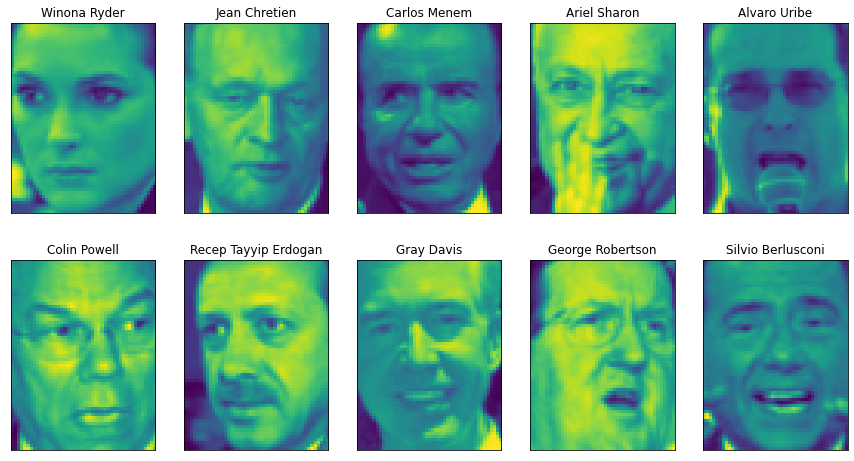

In [4]:
fix, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [23]:
print(people.images.shape)
print(len(people.target_names))

(3023, 62, 47)
62


In [ ]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

In [4]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
x_people = people.data[mask]
y_people = people.target[mask]
# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
x_people = x_people / 255.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_people,y_people, random_state=0)
neigh = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train)
print(neigh.score(x_test,y_test))

0.27906976744186046


# PCA

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [10]:
neigh = KNeighborsClassifier(n_neighbors=1).fit(x_train_pca, y_train)
print(neigh.score(x_test_pca,y_test))

0.33527131782945735


In [11]:
pca.components_.shape

(100, 2914)

# NMF

In [14]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0, max_iter=10000).fit(x_train)
X_train_nmf = nmf.transform(x_train)
X_test_nmf = nmf.transform(x_test)

C:\Users\killt\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Text(0, 0.5, 'Signal')

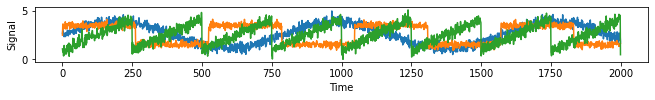

In [22]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(11, 1))
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal")

In [26]:
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
X.shape

(2000, 100)

In [30]:
S_ = NMF(n_components=3, random_state=42, max_iter=10000).fit_transform(X)
H = PCA(n_components=3).fit_transform(X)

C:\Users\killt\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


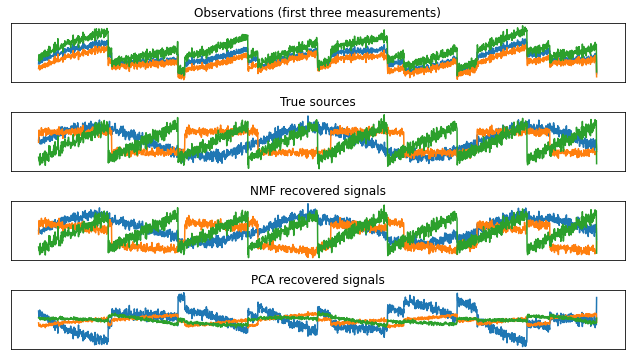

In [35]:
models = [X, S, S_, H]
names = ['Observations (first three measurements)',
'True sources',
'NMF recovered signals',
'PCA recovered signals']

fig, axes = plt.subplots(4, figsize=(11, 6), gridspec_kw={'hspace': .5}, 
    subplot_kw={'xticks': (), 'yticks': ()}
)
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

# comparing clustering algorithms with eigen

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0).fit(x_people)
x_pca = pca.transform(x_people)

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
for ep in [1,3,5,7,9,11,13]:
    print("\n",ep)
    labels = DBSCAN(min_samples=3, eps=ep).fit_predict(x_pca)
    print(np.unique(labels))
    print(np.bincount(labels+1))

In [ ]:
# plot the clusters with dbscan eps7 from previous code lines
from sklearn.cluster import DBSCAN
labels = DBSCAN(min_samples=3, eps=7).fit_predict(x_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4), subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(x_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

In [ ]:
# plot the noises from dbscan min3 eps 15
noise = x_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(20, 12))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

# kmeans

In [8]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(x_pca)
print(np.unique(labels_km))
print(np.bincount(labels_km))

[0 1 2 3 4 5 6 7 8 9]
[132 193 223 177  58 250  75 356 215 384]


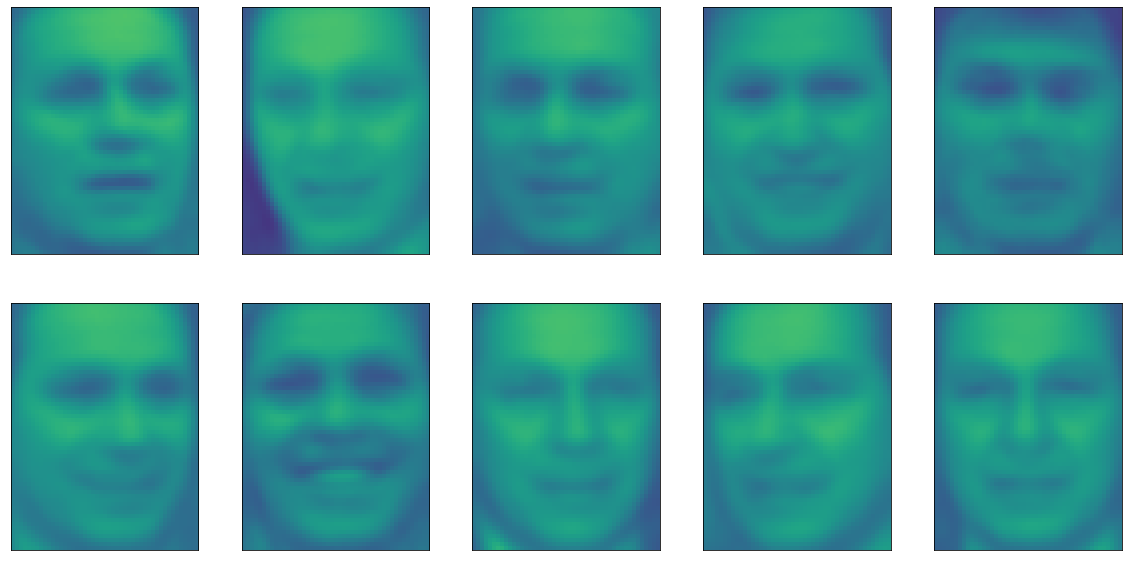

In [6]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(20, 10))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1)

In [ ]:
mglearn.plots.plot_kmeans_faces(km, pca, x_pca, x_people, y_people, people.target_names)

In [ ]:
# The mglearn.plots.plot_kmeans_faces itself
n_clusters = 10
image_shape = (62, 47)
fig, axes = plt.subplots(n_clusters, 11, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 20), gridspec_kw={"hspace": .3})

for cluster in range(n_clusters):
    center = km.cluster_centers_[cluster]
    mask = km.labels_ == cluster
    dists = np.sum((x_pca - center) ** 2, axis=1)
    dists[~mask] = np.inf
    inds = np.argsort(dists)[:5]
    dists[~mask] = -np.inf
    inds = np.r_[inds, np.argsort(dists)[-5:]]
    axes[cluster, 0].imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1)
    for image, label, asdf, ax in zip(x_people[inds], y_people[inds], km.labels_[inds], axes[cluster, 1:]):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title("%s" % (people.target_names[label].split()[-1]), fontdict={'fontsize': 9})

rec = plt.Rectangle([-5, -30], 55, 830, fill=False, lw=2)
rec = axes[0, 0].add_patch(rec)
rec.set_clip_on(False)
axes[0, 0].text(0, -40, "Center")

rec = plt.Rectangle([-5, -30], 280, 830, fill=False, lw=2)
rec = axes[0, 1].add_patch(rec)
rec.set_clip_on(False)
axes[0, 1].text(0, -40, "Close to center")

rec = plt.Rectangle([-5, -30], 280, 830, fill=False, lw=2)
rec = axes[0, 6].add_patch(rec)
rec.set_clip_on(False)
axes[0, 6].text(0, -40, "Far from center")

# agglo

In [7]:
from sklearn.cluster import AgglomerativeClustering
labels_agg = AgglomerativeClustering(n_clusters=10).fit_predict(x_pca)
print(np.unique(labels_agg))
print(np.bincount(labels_agg))

[0 1 2 3 4 5 6 7 8 9]
[540 490 171 287  86  65  48  84  22 270]


In [9]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(labels_agg, labels_km)

0.09846901237503576

Text(0, 0.5, 'Cluster distance')

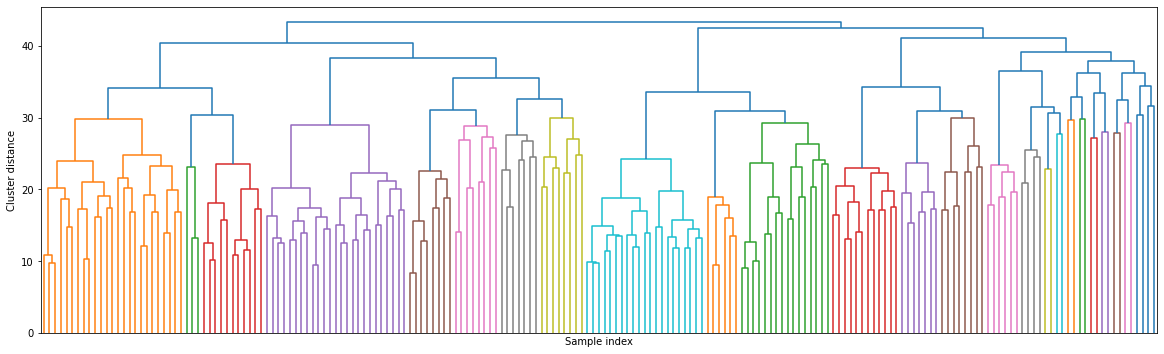

In [14]:
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(x_pca)
# now we plot the dendrogram for the linkage_array - containing the distances between clusters
plt.figure(figsize=(20, 6))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

In [ ]:
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(x_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})

[ 74  92  18 100 179 170 137  66 113  11 108  34  14  44  20  92 140  21
  18  46  40  42  22   8  13   5   3  24 107   8  42  28  34  24  45  22
  13  38  25  23]


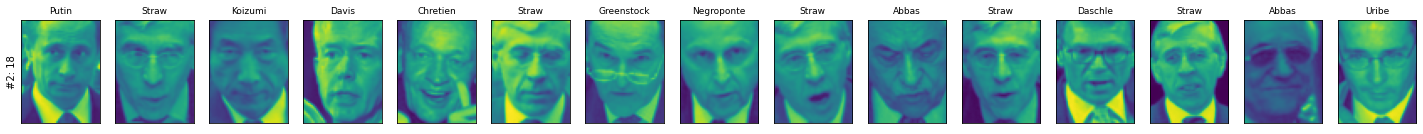

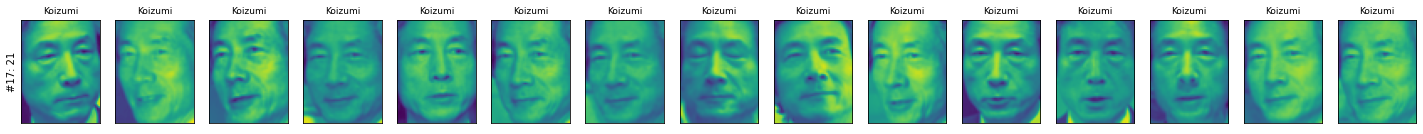

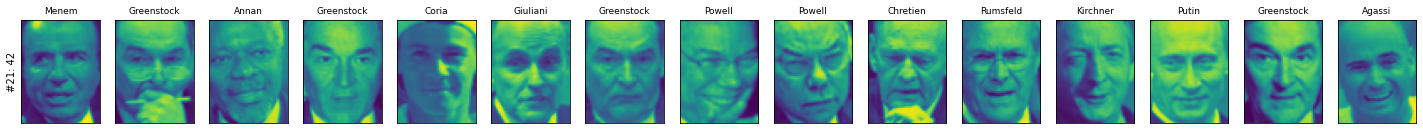

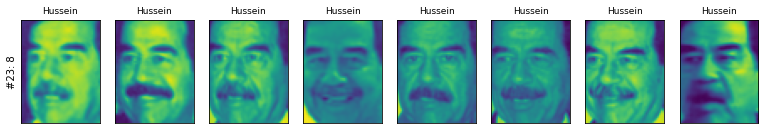

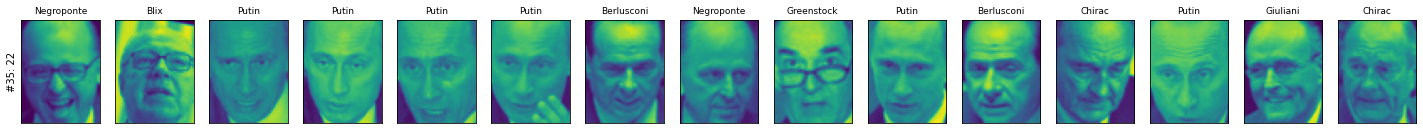

In [29]:
labels_agg = AgglomerativeClustering(n_clusters=40).fit_predict(x_pca)
print(np.bincount(labels_agg))

n_clusters = 40
for cluster in [2,17,21,23,35]: # hand-picked "interesting" clusters
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(25, 10))
    fig.patch.set_facecolor('w')
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(x_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})
        for i in range(cluster_size, 15):
            axes[i].set_visible(False)